# Pecipitation and the Mid-Latitude Seasonal Oscillation (MLSO) index
## Correlation Analysis 
### Zak M

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from scipy.stats import spearmanr
import numpy.ma as ma

#### Loading precip data

In [13]:
path = '/scratch/zmanthos/thesis/'
file = 'gpcp.lat25-55N.lon130-50W.nc'
files = path+file
data = xr.open_dataset(files,decode_times=True,decode_cf=True)
print(len(data['time'].values))
#print(data)

8038


#### Loading the MLSO index

In [4]:
path1 = '/homes/zmanthos/thesis/index/'
file1 ='mlso.index.01011979-08312019.nc'
mlso = xr.open_dataset(path1+file1,decode_times=True,decode_cf=True)
mlso = mlso.sel(time=slice('1997-01-01','2018-12-31'))
print(len(mlso['time'].values))

8035


#### Making Timeseries Match

In [5]:
ndata = data.where(data['time'].isin(mlso['time'].values)).dropna(dim='time',thresh=1000)
test = ndata['time']==mlso['time']
print(test.where(test==True).count(dim='time').values)

8035


#### Calculating Anomalies

In [6]:
clima = ndata['precip'].groupby('time.dayofyear').mean(dim='time')
anoms = ndata['precip'].groupby('time.dayofyear') - clima;
#print(ndata)

#### Calculating Correlation Using Xarray Correlation

In [7]:
core=xr.corr(anoms,mlso['mlso'],dim='time')
#print(core)

#### Plotting Correlation

Setting font color

In [8]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

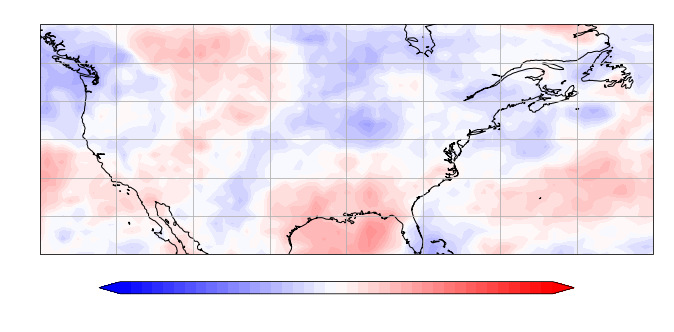

In [9]:
levels=np.linspace(-0.1,0.1,41)

fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.PlateCarree())

cs=ax.contourf(core['longitude'],core['latitude'],
            core,levels = levels, transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')

ax.set_xticks(np.arange(-130,-49,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks(np.arange(25,56,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.coastlines()
ax.gridlines()
plt.title('Correlation: Precipitation Anomalies & MLSO Index',fontsize='x-large',weight='bold')
cbar_ax = fig.add_axes([0.2, 0.25, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Correlation Coefficient')
fig.savefig('gpcp.mlso.corr.png')

#### Calculate Significance using Numpy's Spearman rank-order correlation coefficient 

Switched to Spearman over the Pearson because the Pearson cannot handle nans 

In [10]:
nulls = ndata['precip'].isnull()
count = nulls.where(nulls==True).count()#dim=['longitude','latitude','time'])
print('Nans: ',count.values,'/',20175885, round((count.values/20175885),5))

Nans:  45070 / 20175885 0.00223


In [11]:
llon=len(ndata['longitude'])
llat=len(ndata['latitude'])

pvalmap=np.zeros((llat,llon))
coremap=np.zeros((llat,llon))

precip = anoms;

for y in range(0,llon):
    for x in range(0,llat):
        #print(x,y)
        r,p=spearmanr(mlso['mlso'],precip[:,x,y],nan_policy='omit')
        coremap[x,y]=r
        pvalmap[x,y]=p
print(coremap.shape)
print(pvalmap.shape)



(31, 81)
(31, 81)


#### Plotting with Significance...

Text(0.5, 1.0, 'Correlation between Precipitation Anomalies and the MLSO Index')

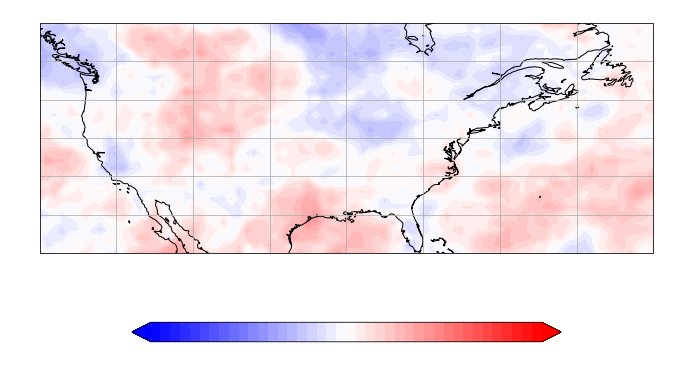

In [12]:
mask = ma.masked_less(pvalmap,0.05)

levels=np.linspace(-0.1,0.1,41)

fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.PlateCarree())

cs=ax.contourf(core['longitude'],core['latitude'],
            coremap,levels = levels, transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')
ax.contourf(core['longitude'],core['latitude'],mask,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['....',''],extend='both',alpha=0)

ax.set_xticks(np.arange(-130,-49,10), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks(np.arange(25,56,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.coastlines()
ax.gridlines()
plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')
plt.title('Correlation between Precipitation Anomalies and the MLSO Index')